In [3]:
import torch
from torch import nn
from transformers import AutoConfig, AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoModel, BertModel
import copy
from anaxnet import AnaXnetGCN
# from radbert import RadBERT
# from bimodal import BimodalModel
import os, json
import pandas as pd
import numpy as np

In [2]:
img_model = AnaXnetGCN(
                num_classes = 9, 
                in_channel1=300, 
                in_channel2=1024)
text_model = RadBERT("StanfordAIMI/RadBERT", 9, dropout=0.1)
for param in text_model.base_model.parameters():
    param.requires_grad = False

# for param in model.base_model.embeddings.parameters():
#     param.requires_grad = False
# for param in model.base_model.encoder.parameters():
#     param.requires_grad = False
model = BimodalModel(img_model, text_model)

Some weights of the model checkpoint at StanfordAIMI/RadBERT were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.img_model

In [6]:
tokenizer = AutoTokenizer.from_pretrained("StanfordAIMI/RadBERT", use_fast=True)

In [14]:

config = AutoConfig.from_pretrained("StanfordAIMI/RadBERT")
config.hidden_size = 1024

m = BertModel.from_pretrained("StanfordAIMI/RadBERT", config= config, add_pooling_layer=False)

ValueError: The hidden size (1024) is not a multiple of the number of attention heads (12)

In [18]:
1024/12

85.33333333333333

In [3]:
model = BertModel.from_pretrained("StanfordAIMI/RadBERT")
# model.pooler = None
print(model)

Some weights of the model checkpoint at StanfordAIMI/RadBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [28]:
diseases = ["Lung opacity", "Pleural effusion", "Atelectasis", "Enlarged cardiac silhouette", "Pulmonary edema/hazy opacity", 
            "Pneumothorax", "Consolidation" , "Fluid overload/heart failure", "Pneumonia"]

model = BertModel.from_pretrained("StanfordAIMI/RadBERT")
embedding_cpy = copy.deepcopy(model.embeddings)
encoder_cpy = copy.deepcopy(model.encoder)
print(nn.ModuleDict({'embeddings':embedding_cpy,'encoder':encoder_cpy}))

Some weights of the model checkpoint at StanfordAIMI/RadBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ModuleDict(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [23]:
class RadBERT(nn.Module):
  def __init__(self, base_mod_name, NUM_CLASSES, dropout=0.1):
    super(RadBERT, self).__init__()
    self.config= AutoConfig.from_pretrained(base_mod_name)
    bert = BertModel.from_pretrained(base_mod_name, config = self.config)

    embedding_cpy = copy.deepcopy(bert.embeddings)
    encoder_cpy = copy.deepcopy(bert.encoder)

    self.base_model = nn.ModuleDict({'embeddings':embedding_cpy,'encoder':encoder_cpy})
    
    self.dense = nn.Linear(768, 768, bias=True)
    self.tanh = nn.Tanh()
    self.dropout = nn.Dropout(dropout)
    self.classifier = nn.Linear(768, NUM_CLASSES, bias=True)
    # self.relu = nn.ReLU()
    
  def forward(self, inputs, attention_mask):
    encoder_out = []
    for i in range(18):
      bert_out = self.base_model(inputs[:,i,:], attention_mask=attention_mask[:,i,:])
      print(bert_out.keys())
      encoder_out.append(bert_out['encoder'])

    out = torch.permute(torch.stack(encoder_out, dim=0), (1,0,2))

    out = self.dense(out)
    out = self.tanh(out)
    out = self.dropout(out)
    logits = self.classifier(out)
    return out, logits

mod = RadBERT("StanfordAIMI/RadBERT", len(diseases))

Some weights of the model checkpoint at StanfordAIMI/RadBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
print(mod)

RadBERT(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [15]:
model = AutoModel.from_pretrained("StanfordAIMI/RadBERT")
print(model)

Some weights of the model checkpoint at StanfordAIMI/RadBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [19]:
[name for name, _ in model.named_children()]
model.embeddings


BertEncoder(
  (layer): ModuleList(
    (0-11): 12 x BertLayer(
      (attention): BertAttention(
        (self): BertSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): BertOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [17]:
model.get_submodule('embeddings')

BertEmbeddings(
  (word_embeddings): Embedding(28996, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [14]:
print(model.get)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [13]:
model.get_submodule('pooler').parameters()

<generator object Module.parameters at 0x2b2393851120>

In [14]:
model = AutoModelForSequenceClassification.from_pretrained("StanfordAIMI/RadBERT", num_labels=len(diseases), problem_type="multi_label_classification")
print(model)

Some weights of the model checkpoint at StanfordAIMI/RadBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at StanfordAIMI/RadBERT and

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [2]:
import pandas as pd

In [3]:
mm_feature_dir = '/n/holyscratch01/protopapas_lab/Everyone/eghitmangilkes/data/imagenome/chest-imagenome/silver_dataset/mm_feature_extraction_final_emptystr/empty_counts.csv'
d = pd.read_csv(mm_feature_dir)

In [4]:
d

,num_empty
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,0.0
8,1.0
9,1.0


In [13]:
a = torch.arange(60.).reshape(3, 4, 5)
b = torch.arange(60.).reshape(3, 4, 5)
torch.tensordot(a, b, dims=([0,1,2], [0,1,2])).shape


torch.Size([])

In [8]:
N = 4
C = 18
Z = 9
a = torch.randn(N, C, Z)
b = torch.randn(C, Z)

# c = torch.sum(a * b, dim=-1)
c = a * b
print(c.shape)

torch.Size([4, 18, 9])


In [12]:
t = a[0] * b

tensor([[True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, T

In [6]:
diff = (a[0,:,:] - b[0,:,:]).sum(dim=1).abs()
torch.where(diff > 0.5, diff, 0.5)

tensor([4.0425, 2.5319, 1.5599, 0.6632, 1.2041, 4.9101, 0.5000, 9.5585, 4.8430,
        3.2396, 5.5715, 1.3648, 4.2021, 3.4838, 5.2263, 3.9321, 0.5000, 0.5000])

In [17]:
torch.dot(a[0,0,:], b[0,0,:])

tensor(12.0858)

In [18]:
c

tensor([[ 12.0858, -32.0594,  -1.4341,  13.8149, -31.8340, -50.2087,  15.9532,
          77.4449,   0.7687,   1.4410,   0.8537,  -0.2162,  55.5379,  17.0659,
          18.0514,  -0.7264, -85.2714, -82.6724],
        [ 10.7384, -74.0595,  13.7776, -18.2815,  41.5231,  20.0348,  20.5066,
         -53.3604,   3.6874,   3.6221, -34.2320,  23.2193,  17.1780, -15.4609,
          35.8195, -59.3559,  62.7089, -32.9077],
        [ -4.9354, -73.0743, -21.0928, -44.0023,   8.7573,   5.9563,  64.9588,
          -3.2974,   0.3018,  24.2778,  32.8651,  47.9866,  -6.1385, -76.7742,
           0.4527,  18.1498, -11.8616,  49.4063],
        [-29.8745,  71.4288,  23.8092,  -9.0315, -83.3448, -23.7323, -23.3096,
         -13.6323, -53.6783,   3.5738, -28.5712, -41.1460, -13.2196,   5.0974,
         -44.5141, -38.9843,  43.0168,  24.8751]])

In [4]:
class_counts = pd.read_csv('/n/holyscratch01/protopapas_lab/Everyone/eghitmangilkes/data/imagenome/chest-imagenome/silver_dataset/class_counts/train_class_counts.csv')
obj_counts = pd.read_csv('/n/holyscratch01/protopapas_lab/Everyone/eghitmangilkes/data/imagenome/chest-imagenome/silver_dataset/class_counts/object_counts.csv')
new_train = pd.read_csv('/n/holyscratch01/protopapas_lab/Everyone/eghitmangilkes/data/imagenome/chest-imagenome/silver_dataset/coco/updated/new_train.csv')

In [5]:
class_counts['total'] = obj_counts.values

In [6]:
weights = class_counts.drop(labels='total', axis=1).divide(obj_counts.values)

In [57]:
class_counts.sum(axis=0)

0         510583.0
1         189134.0
2         179009.0
3          40090.0
4         115606.0
5          17495.0
6          39400.0
7          18033.0
8          71165.0
total    2899196.0
dtype: float64

In [13]:
weights.to_csv('/n/holyscratch01/protopapas_lab/Everyone/eghitmangilkes/data/imagenome/chest-imagenome/silver_dataset/class_counts/class_weights.csv', index=False)

In [23]:
def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: torch.Tensor,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

    Args:
        inputs (Tensor): A float tensor of arbitrary shape.
                The predictions for each example.
        targets (Tensor): A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha (float): Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default: ``0.25``.
        gamma (float): Exponent of the modulating factor (1 - p_t) to
                balance easy vs hard examples. Default: ``2``.
        reduction (string): ``'none'`` | ``'mean'`` | ``'sum'``
                ``'none'``: No reduction will be applied to the output.
                ``'mean'``: The output will be averaged.
                ``'sum'``: The output will be summed. Default: ``'none'``.
    Returns:
        Loss tensor with the reduction option applied.
    """
    # Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py

    # if not torch.jit.is_scripting() and not torch.jit.is_tracing():
    #     _log_api_usage_once(sigmoid_focal_loss)
    p = torch.sigmoid(inputs)
    ce_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    
    alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
    loss = alpha_t * loss

    # Check reduction option and return loss accordingly
    if reduction == "none":
        pass
    elif reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()
    else:
        raise ValueError(
            f"Invalid Value for arg 'reduction': '{reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
        )
    return loss

In [19]:
b.size()

torch.Size([4, 18, 9])

In [25]:
# focal = FocalLoss(gamma=0.6, alpha=weights)
N = 4
C = 18
Z = 9
a = torch.randn(N, C, Z)
b = torch.randint(high=1, size=(4,18,9))
d = torch.randn(C, Z)

sigmoid_focal_loss(inputs=a, targets=b.float(), alpha=d).shape
# focal(a,b)

torch.Size([4, 18, 9])

In [52]:
img_model = AnaXnetGCN(
            num_classes = 9, 
            in_channel1=300, 
            in_channel2=1024)
text_model = RadBERT("StanfordAIMI/RadBERT", 9, dropout=0.1)
for param in text_model.base_model.parameters():
    param.requires_grad = False

# for param in model.base_model.embeddings.parameters():
#     param.requires_grad = False
# for param in model.base_model.encoder.parameters():
#     param.requires_grad = False
model = BimodalModel(img_model, text_model)

Some weights of the model checkpoint at StanfordAIMI/RadBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'bert.pooler.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
output_dir = '/n/holyscratch01/protopapas_lab/Everyone/eghitmangilkes/bimodal-output-3epochs/checkpoint_latest.pt'
model_checkpoint = torch.load(output_dir)
model.load_state_dict(model_checkpoint['state_dict'])

In [11]:
path = output_dir = '/n/holyscratch01/protopapas_lab/Everyone/eghitmangilkes/AnaXnet-Output-focal-25-2/eval_metrics_focal_25_2.json'
with open(path, 'r') as f:
    metrics_uni = json.load(f)


In [12]:
for disease in metrics_uni['accuracy'].keys():
    print(np.mean(list(metrics_uni['accuracy'][disease].values())))

0.8403204212885784
0.9376085870842038
0.9402392960391652
0.9863177343077741
0.961436198273861
0.9943353005033987
0.9865264090822765
0.9940586305776539
0.9764877456324839


In [13]:
metrics_uni['aucs']

{'0': {'0': 0.774416245301139,
  '1': 0.5452591185973217,
  '2': 0.6333425131948143,
  '3': 0.639020080515967,
  '4': 0.6988648720921775,
  '5': 0.7549062154415599,
  '6': 0.7276446821395081,
  '7': 0.7771958565015773,
  '8': 0.5440602508939253,
  '9': 0.6279523872913884,
  '10': 0.62657175985079,
  '11': 0.7190381010696371,
  '12': 0.7563997170563861,
  '13': 0.7232212042792338,
  '14': nan,
  '15': nan,
  '16': nan,
  '17': nan},
 '1': {'0': 0.8065122813133909,
  '1': nan,
  '2': 0.7059584906090335,
  '3': 0.7676051334598855,
  '4': 0.8075827603504481,
  '5': nan,
  '6': 0.7955030149631305,
  '7': 0.7921305180385533,
  '8': nan,
  '9': 0.7201850887824242,
  '10': 0.7382751842510574,
  '11': 0.7831675052600595,
  '12': nan,
  '13': 0.7731487575487428,
  '14': nan,
  '15': nan,
  '16': nan,
  '17': nan},
 '2': {'0': 0.7113666856049815,
  '1': nan,
  '2': 0.6311652410790016,
  '3': 0.6591677552034518,
  '4': 0.7053005840412787,
  '5': 0.6161611633147241,
  '6': 0.7203911049427232,
  '7'

In [6]:
for disease in metrics_uni['aucs'].keys():
    print(np.nanmean(list(metrics_uni['aucs'][disease].values())))

0.6819923574446732
0.7690068734576725
0.6744791602356583
0.822775782811232
0.7580829217119321
0.7495161874755868
0.7165638535299732
0.7137923674884519
0.6577486143578339


In [7]:
path = '/n/holyscratch01/protopapas_lab/Everyone/eghitmangilkes/bimodal-dualanax-output-focal-weights-2/eval_metrics_focal_weights_2.json'
with open(path, 'r') as f:
    metrics = json.load(f)

In [8]:
for disease in metrics['accuracy'].keys():
    print(np.mean(list(metrics['accuracy'][disease].values())))

0.8541257816511567
0.9377738856415342
0.9402017814729626
0.9863165619775803
0.9613142759337023
0.9943353005033987
0.9865264090822765
0.9940586305776539
0.9764877456324839


In [10]:
metrics['aucs']

{'0': {'0': 0.7232500465047744,
  '1': 0.5166623083555818,
  '2': 0.5996862624065382,
  '3': 0.6057485168718808,
  '4': 0.6881365665766741,
  '5': 0.7261240012685392,
  '6': 0.806522576984209,
  '7': 0.732727826389816,
  '8': 0.5092388430072922,
  '9': 0.6073468754977678,
  '10': 0.6006793959561788,
  '11': 0.6968519854614934,
  '12': 0.7388555630622597,
  '13': 0.7816240160701466,
  '14': nan,
  '15': nan,
  '16': nan,
  '17': nan},
 '1': {'0': 0.7856797763372552,
  '1': nan,
  '2': 0.6859885052419807,
  '3': 0.7198794033223204,
  '4': 0.7828211278603328,
  '5': nan,
  '6': 0.7835679306262148,
  '7': 0.7798210078955258,
  '8': nan,
  '9': 0.7314688549792177,
  '10': 0.7128297250106435,
  '11': 0.7715872385527814,
  '12': nan,
  '13': 0.7613969051930704,
  '14': nan,
  '15': nan,
  '16': nan,
  '17': nan},
 '2': {'0': 0.6893148403504915,
  '1': nan,
  '2': 0.595675403743809,
  '3': 0.6131714516440316,
  '4': 0.6915505430616186,
  '5': 0.5732643783698493,
  '6': 0.6813932947695825,
  '7

In [9]:
for disease in metrics['aucs'].keys():
    print(np.nanmean(list(metrics['aucs'][disease].values())))

0.6666753417437966
0.7515040475019342
0.6462919188216006
0.8169400354558127
0.7374641872718022
0.7090797101578814
0.6899800113034026
0.6636150023679939
0.607854380638534


In [11]:
anatomy = pd.read_csv('/n/holyscratch01/protopapas_lab/Everyone/eghitmangilkes/data/imagenome/chest-imagenome/silver_dataset/coco/anatomy_matrix.csv', sep='\t')


In [6]:
import matplotlib.pyplot as plt
import networkx as nx

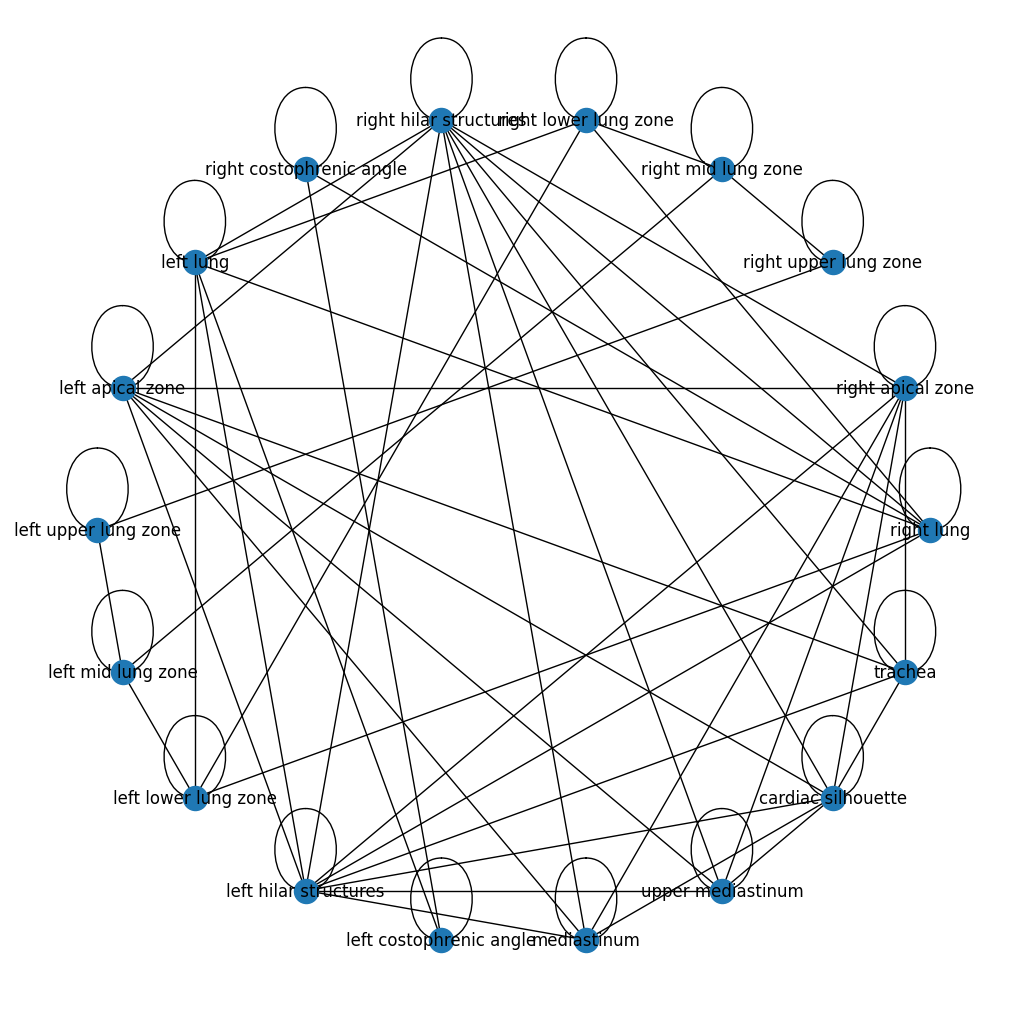

In [27]:


# Generating sample data
# G = nx.florentine_families_graph()
# adjacency_matrix = nx.adjacency_matrix(G)

# The actual work
# You may prefer `nx.from_numpy_matrix`.
fig, ax = plt.subplots(figsize=(13,13))
G2 = nx.from_pandas_adjacency(anatomy)
nx.draw_circular(G2, with_labels=True, ax=ax)
plt.axis('equal')
plt.savefig('anatomy_matrix.png', dpi=300)

In [16]:
anatomy.index = anatomy.columns

In [17]:
anatomy

,right lung,right apical zone,right upper lung zone,right mid lung zone,right lower lung zone,right hilar structures,right costophrenic angle,left lung,left apical zone,left upper lung zone,left mid lung zone,left lower lung zone,left hilar structures,left costophrenic angle,mediastinum,upper mediastinum,cardiac silhouette,trachea
right lung,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
right apical zone,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
right upper lung zone,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
right mid lung zone,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
right lower lung zone,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
right hilar structures,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
right costophrenic angle,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
left lung,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
left apical zone,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
left upper lung zone,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
from collections import OrderedDict

In [44]:
n_classes = len(diseases)
path = '/n/holyscratch01/protopapas_lab/Everyone/eghitmangilkes/data/imagenome/chest-imagenome/silver_dataset/coco/updated/'
model_path = '/n/holyscratch01/protopapas_lab/Everyone/eghitmangilkes/bimodal-dualanax-output-focal-weights-2/'

model = BimodalModel(n_classes = n_classes)

# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     model = nn.DataParallel(model, device_ids = [0,4])

print('Restoring model weights from {}'.format(os.path.join(model_path, 'checkpoint_latest.pt')))
model_checkpoint = torch.load(os.path.join(model_path, 'checkpoint_latest.pt'))
# state_dict = torch.load(model_path)
# create new OrderedDict that does not contain `module.`
# 
new_state_dict = OrderedDict()
for k, v in model_checkpoint['state_dict'].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

Restoring model weights from /n/holyscratch01/protopapas_lab/Everyone/eghitmangilkes/bimodal-dualanax-output-focal-weights-2/checkpoint_latest.pt


In [47]:
model.load_state_dict(model_checkpoint['state_dict'])


<All keys matched successfully>

In [46]:
model_checkpoint['state_dict']

OrderedDict([('img_model.anatomy_inp_tensor',
              tensor([[1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
                      [0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.],
                      [0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                      [1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
                      [1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.],
                      [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
                      [1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
                      [0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.],
                      [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,